In [2]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt
from sklearn.svm import SVC as svm
# from cv2 import ml_SVM as svm
from skimage.feature import hog
from sklearn.metrics import RocCurveDisplay as roc_display
from sklearn.metrics import PrecisionRecallDisplay as pr_display
import pickle
import json

## load parameters

In [2]:
parameters = json.load(open('parameters.json'))
train_size = parameters['train_size']
validation_size = parameters['validation_size']
test_size = parameters['test_size']

## load files

In [14]:
# iterate throw dataset directories

face_img_list = []
for d in os.listdir('lfw'):
    if d[0] == '.':
        continue
    for img in os.listdir('lfw/' + d):
        face_img_list.append('lfw/' + d + '/' + img)


non_face_img_list = []
size_list = []
for img in os.listdir('257.clutter'):   
    if img[0] == '.':
        continue 
    non_face_img_list.append('257.clutter/' + img)
    try:
        size_list.append(cv.imread('257.clutter/' + img).shape[:2])
    except:
        print(img)



## take samples from non-face images

In [27]:
sample_dims = parameters['sample_dims']

non_face_sample_map = []

for i in range(len(non_face_img_list)):
    for b_x in range(0, size_list[i][0] - sample_dims[0], 50):
        for b_y in range(0, size_list[i][1] - sample_dims[1], 50):
            non_face_sample_map.append([non_face_img_list[i], b_x, b_y])

get_sample_from_map = lambda map: cv.imread(map[0])[map[1]:map[1]+sample_dims[0], map[2]:map[2]+sample_dims[1], ::-1]


## choose parameters for HOG

In [21]:
number_of_orientations = parameters['number_of_orientations']
pixels_per_cell = parameters['pixels_per_cell']
cells_per_block = parameters['cells_per_block']


extract_feature_vector = lambda img: hog(img,orientations=number_of_orientations, 
                                            pixels_per_cell=pixels_per_cell,
                                            cells_per_block=cells_per_block,
                                            channel_axis=2)


img = cv.imread(face_img_list[20])[50:-50,50:-50,::-1]
tmp , hog_image = hog(img,orientations=number_of_orientations,
                        pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, 
                        channel_axis=2, visualize=True)

f, a = plt.subplots(1, 2)
f.set_figwidth(10)
f.set_figheight(5)
a[0].imshow(img)
a[1].imshow(hog_image)
print(tmp.shape)

NameError: name 'face_img_list' is not defined

## extract features from samples

In [55]:
features = []
for i in range(len(face_img_list)):
    if i % 1000 == 0:
        print(i)
    img = cv.imread(face_img_list[i])[50:-50,50:-50]
    features.append(extract_feature_vector(img))



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [56]:
features = np.array(features)
np.save('positive_features.npy', features)

In [57]:
del features

In [62]:
features = []
for i in range(len(non_face_img_list)):
    if i % 100 == 0:
        print(i)
    img = cv.imread(non_face_img_list[i])
    for b_x in range(0, img.shape[0] - sample_dims[0], 50):
        for b_y in range(0, img.shape[1] - sample_dims[1], 50):
            features.append(extract_feature_vector(img[b_x:b_x+sample_dims[0], b_y:b_y+sample_dims[1]]))

features = np.array(features)
np.save('negative_features.npy', features)
del features


0
100
200
300
400
500
600
700
800


## create training, validation, and test sets

In [69]:
positive_features = np.load('positive_features.npy')
positive_permutation = np.random.permutation(positive_features.shape[0])


negative_features = np.load('negative_features.npy')
negative_permutation = np.random.permutation(negative_features.shape[0])

np.save('validation_features.npy',np.concatenate([positive_features[positive_permutation[:validation_size]], 
                                                  negative_features[negative_permutation[:validation_size]]], axis=0))


np.save('test_features.npy',np.concatenate([positive_features[positive_permutation[validation_size:validation_size+test_size]], 
                                            negative_features[negative_permutation[validation_size:validation_size+test_size]]], axis=0))

positive_features = positive_features[positive_permutation[validation_size+test_size:validation_size+test_size+train_size]]
negative_features = negative_features[negative_permutation[validation_size+test_size:validation_size+test_size+train_size]]

np.save('train_features.npy', np.concatenate([positive_features, negative_features], axis=0))

del positive_features
del negative_features



## train classifier

In [11]:
features = np.load('train_features.npy')
labels = np.concatenate([np.ones(train_size), np.zeros(train_size)], axis=0)

classifier = svm()

classifier.fit(features, labels)
# classifier.trainAuto(features[:10], cv.ml.ROW_SAMPLE, labels[:10])
del features

## evaluate classifier

In [12]:
features = np.load('validation_features.npy')
labels = np.concatenate([np.ones(validation_size), np.zeros(validation_size)], axis=0)

prediction_on_validation_set = classifier.predict(features)

del features

In [13]:
(labels != prediction_on_validation_set).sum()

6

## save classifier

In [ ]:
pickle.dump(classifier, open('classifier.pickle', 'wb'))

## detect faces

In [2]:
def add_padding(image, sample_dims):
    padded_current_image = np.zeros((sample_dims[0] + image.shape[0],
                                     sample_dims[1] + image.shape[1],
                                     3))
        
    shift = np.array(padded_current_image.shape[:2]) - np.array(image.shape[:2])
    shift = (shift / 2).astype(int)
    padded_current_image[shift[0]:image.shape[0]+shift[0], shift[1]:image.shape[1]+shift[1], :] = image

    return padded_current_image, shift

In [3]:
def detect_faces(image):

    parameters = json.load(open('parameters.json'))

    number_of_orientations = parameters['number_of_orientations']
    pixels_per_cell = parameters['pixels_per_cell']
    cells_per_block = parameters['cells_per_block']


    extract_feature_vector = lambda img: hog(img,orientations=number_of_orientations, 
                                            pixels_per_cell=pixels_per_cell,
                                            cells_per_block=cells_per_block,
                                            channel_axis=2)



    sample_dims = parameters['sample_dims']
    strides = parameters['sliding_window_strides']

    levels = parameters['levels']

    svm_classifier = pickle.load(open('classifier.pickle', 'rb'))
    decision_threshold = parameters['decision_function_threshold']
    
    
    bounding_boxes = []
    for i in range(len(levels)):
        resize_factor = levels[i]
        stride = strides[i]
        print("level {i}".format(i=i))

        # Padding the image 
        current_image = cv.resize(image, (0,0), fx = resize_factor, fy = resize_factor)
        padded_current_image, shift = add_padding(current_image, sample_dims=sample_dims)
        del current_image

        
        feature_vectors = []
        for b_x in range(0, padded_current_image.shape[0] - sample_dims[0], stride):
            for b_y in range(0, padded_current_image.shape[1] - sample_dims[1], stride):
                sample = padded_current_image[b_x:b_x+sample_dims[0], b_y:b_y+sample_dims[1]]
                feature_vector = extract_feature_vector(sample)
                
                p = svm_classifier.decision_function(feature_vector.reshape(1, -1))
                del feature_vector
                if p > decision_threshold:
                    bounding_boxes.append([(b_x - shift[0]) / resize_factor, (b_y - shift[1]) / resize_factor, 
                                           sample_dims[0] / resize_factor, sample_dims[1] / resize_factor, 
                                           p])
                
        del padded_current_image
        
        
    

    return bounding_boxes
    

In [4]:
def eliminate_redundante_boxes(bounding_boxes):

    parameters = json.load(open('parameters.json'))

    accepting_threshold = parameters['decision_function_threshold']

    bounding_boxes = np.array(bounding_boxes)
    bounding_boxes = bounding_boxes[np.argsort(-bounding_boxes[:, 4])]


    accepted_bounding_boxes = []

    for i in range(bounding_boxes.shape[0]):
        if bounding_boxes[i, 4] < accepting_threshold:
            break
        surface_area = bounding_boxes[i, 2] * bounding_boxes[i, 3]
        flag = True
        for b in accepted_bounding_boxes:
            # calculate surface area of intersection
            left = max(bounding_boxes[i, 0], b[0])
            right = min(bounding_boxes[i, 0] + bounding_boxes[i, 2], b[0] + b[2])
            top = max(bounding_boxes[i, 1], b[1])
            bottom = min(bounding_boxes[i, 1] + bounding_boxes[i, 3], b[1] + b[3])


            if left < right and top < bottom:
                intersection_area = (right - left) * (bottom - top)
                
                if (intersection_area / (b[2] * b[3] + surface_area - intersection_area)) > 0.6:
                    flag = False
                    break
                if intersection_area / surface_area > .6:
                    flag = False
                    break
                if intersection_area / (b[2] * b[3]) > .8:
                    flag = False
                    break

        if flag:
            accepted_bounding_boxes.append(bounding_boxes[i])
        


    return accepted_bounding_boxes

In [5]:
def get_detection_image(image):
    tmp = image.copy()
    detection_bounding_boxes = detect_faces(tmp)
    bounding_boxes = eliminate_redundante_boxes(detection_bounding_boxes)
    
    
    tmp_with_boxes = tmp.copy()

    for bb in bounding_boxes:
        r, b, g = np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)
        cv.rectangle(tmp_with_boxes, (int(bb[1]), int(bb[0])), (int(bb[1]+bb[3]), int(bb[0]+bb[2])),(r,g,b), 2)
        cv.putText(tmp_with_boxes, str(bb[4])[:5], (int(bb[1]), int(bb[0])), cv.FONT_HERSHEY_SIMPLEX, .5, (r,g,b), 2)

    


    return tmp_with_boxes

In [14]:
tmp = cv.imread('Esteghlal.jpg')
detection_bounding_boxes = detect_faces(tmp)
    


level 0
level 1
level 2


In [15]:
bounding_boxes = eliminate_redundante_boxes(detection_bounding_boxes)

# bounding_boxes = np.array(detection_bounding_boxes)
# bounding_boxes = bounding_boxes[bounding_boxes[:,3] == 150]
tmp_with_boxes = tmp.copy()


for i in range(len(bounding_boxes)):
    bb = bounding_boxes[i]
    r, b, g = np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)
    cv.rectangle(tmp_with_boxes, (int(bb[1]), int(bb[0])), (int(bb[1]+bb[3]), int(bb[0]+bb[2])),(r,g,b), 2)
    cv.putText(tmp_with_boxes, str(bb[4])[:5] + "|"+str(i), 
                                  (int(bb[1]), int(bb[0])), 
                                    cv.FONT_HERSHEY_SIMPLEX, 1, (r,g,b), 2,
                                    bottomLeftOrigin=False)

cv.imwrite('tmp.jpg', tmp_with_boxes)    


True

In [6]:
cv.imwrite('res04.jpg', get_detection_image(cv.imread('Melli.jpg')))

level 0
level 1
level 2
level 3
level 4
level 5


/var/folders/h4/c2hzt9rs3qv9lbm1_zj3vqv40000gn/T/ipykernel_44199/344695064.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounding_boxes = np.array(bounding_boxes)


True

In [7]:
cv.imwrite('res05.jpg', get_detection_image(cv.imread('Persepolis.jpg')))

level 0
level 1
level 2
level 3
level 4
level 5


/var/folders/h4/c2hzt9rs3qv9lbm1_zj3vqv40000gn/T/ipykernel_44199/344695064.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounding_boxes = np.array(bounding_boxes)


True

In [8]:
cv.imwrite('res06.jpg', get_detection_image(cv.imread('Esteghlal.jpg')))

level 0
level 1
level 2
level 3
level 4
level 5


/var/folders/h4/c2hzt9rs3qv9lbm1_zj3vqv40000gn/T/ipykernel_44199/344695064.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounding_boxes = np.array(bounding_boxes)


True

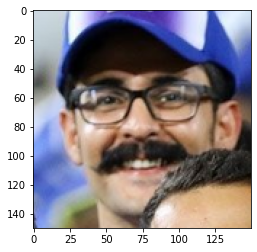

In [9]:
tmp_base = [30, 330]

tmp_size = (int)(150 / .8)

sample = cv.imread('Esteghlal.jpg')[tmp_base[0]:tmp_base[0] + tmp_size,
                                     tmp_base[1]:tmp_base[1] + tmp_size]
# sample = np.concatenate([ np.zeros((20, 250, 3)),sample], axis = 0)
sample = cv.resize(sample, (150,150)).astype(int)
plt.imshow(sample[:,:,::-1])

In [10]:
parameters = json.load(open('parameters.json'))

number_of_orientations = parameters['number_of_orientations']
pixels_per_cell = parameters['pixels_per_cell']
cells_per_block = parameters['cells_per_block']


extract_feature_vector = lambda img: hog(img,orientations=number_of_orientations, 
                                            pixels_per_cell=pixels_per_cell,
                                            cells_per_block=cells_per_block,
                                            channel_axis=2)


tmp_vector = extract_feature_vector(sample)
svm_classifier = pickle.load(open('classifier.pickle', 'rb'))
print(tmp_vector.shape)
prediction = svm_classifier.predict(tmp_vector.reshape((1, -1)))

print(prediction)
print(svm_classifier.decision_function(tmp_vector.reshape((1, -1))))

(23040,)
[1.]
[0.95472257]


In [4]:
classifier = pickle.load(open('classifier.pickle', 'rb'))

In [8]:
print(classifier.gamma)
print(classifier.get_params(deep=True))


scale
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


## draw performance plots

In [2]:
parameters = json.load(open('parameters.json'))

svm_classifier = pickle.load(open('classifier.pickle', 'rb'))

test_feature_vectors = np.load('test_features.npy')

ground_truth_labels = np.concatenate([np.ones(parameters['test_size']), np.zeros(parameters['test_size'])])

prediction = svm_classifier.predict(test_feature_vectors)


del test_feature_vectors

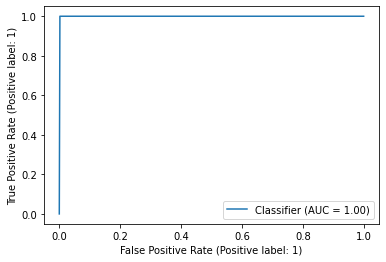

In [5]:

ROC_plot = roc_display.from_predictions(prediction, ground_truth_labels)

plt.savefig('res01.jpg')

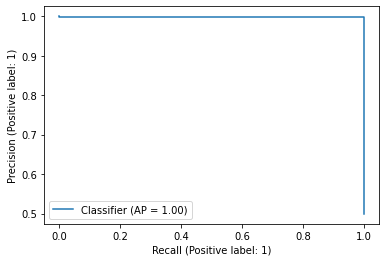

In [8]:
precision_recall_plot = pr_display.from_predictions(prediction, ground_truth_labels)

plt.savefig('res02.jpg')